<a href="https://colab.research.google.com/github/rtjord/ece570-project/blob/main/ECE_570_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Tiny Reproduction of CutMix on CIFAR-100 and Tiny ImageNet

>[A Tiny Reproduction of CutMix on CIFAR-100 and Tiny ImageNet](#scrollTo=pGH7Z0hfEAtY)

>[Overview](#scrollTo=Qqcd8t6G7fmR)

>>[What you’ll do](#scrollTo=Qqcd8t6G7fmR)

>>[Outputs & visuals](#scrollTo=Qqcd8t6G7fmR)

>>[Run order (per dataset)](#scrollTo=Qqcd8t6G7fmR)

>[Runtime Setup](#scrollTo=Fl4iaIoSETEz)

>>[Set Up File Directory](#scrollTo=4zb6uHYTGawp)

>>[Set Seed](#scrollTo=4URjJlVfGmKh)

>>[Print Device Info and Package Versions](#scrollTo=zV1SAaGiG1Xk)

>[Helpers](#scrollTo=IEoTzlq7wBZn)

>>[Get Device](#scrollTo=Z2yIwlSWHrRN)

>[Load Data](#scrollTo=5dzCEj2jusP6)

>>[Make Augmentations](#scrollTo=MFQblUZxrvtO)

>>[Make Transforms](#scrollTo=wlwgTPZLIVDf)

>>[CIFAR-100 Data Loaders](#scrollTo=DPX6N4KUJIux)

>>[Download Tiny ImageNet](#scrollTo=-9t303LUJwBC)

>>[Construct Tiny ImageNet Validation](#scrollTo=wbRB1FwlKQfD)

>>[Tiny ImageNet Data Loaders](#scrollTo=WZTDt77PKdEW)

>[Build Model](#scrollTo=w6WhObE6vh5B)

>[Train Model](#scrollTo=6GdW2IhbvtSt)

>>[Soft Categorical Cross-Entropy](#scrollTo=06Y2AhjzO98A)

>>[Plotting Helper](#scrollTo=ub-tpV1hPVU2)

>>[Train One Epoch](#scrollTo=LfO7wYCjOW4e)

>>[Training Loop](#scrollTo=jRmkAvixWdmc)

>[Evaluate Model](#scrollTo=m2jQXMHEvvjc)

>[Run Experiment (Train + Test)](#scrollTo=RUA1Ycgj1hS5)

>[Global Config](#scrollTo=egwwakGrE2Dk)

>[ResNet-50 CIFAR-100](#scrollTo=119xYLjkFQhC)

>>[Baseline](#scrollTo=053-lvam1kUF)

>>[CutMix](#scrollTo=Ft9_i0T49uRm)

>[ResNet-18 CIFAR-100](#scrollTo=FZjvvYroFpBh)

>>[Baseline](#scrollTo=Ddt8Gj7k8Plf)

>>[CutMix](#scrollTo=rmH6Wp23Ca1Z)

>>[Cutout](#scrollTo=e9Y80pGNkehE)

>>[MixUp](#scrollTo=_oGl1HoIkiFq)

>[Comparison](#scrollTo=dC2pUTymlNXU)

>[Create Figures](#scrollTo=gH90e69ybkUF)

>>[Data Augmentation Examples](#scrollTo=TgIT35UtnnWl)

>>[Training History](#scrollTo=uVnbU2CCnsZW)



# Overview

**Goal:** Trains and evaluate a single ResNet-18 on two datasets with shared code, clear stats, and useful visuals.

## What you’ll do
- **Load & explore data (no transforms):** dataset sizes, class names, quick image grids.
- **Show base transforms:** preview train/eval pipelines (resize/crop/normalize).
- **Visualize MixUp & CutMix:** see how each augmentation alters a batch.
- **Build the model:** load ImageNet-pretrained ResNet-18; swap the head to match classes (100 for CIFAR-100, 200 for Tiny ImageNet).
- **Train in two phases per dataset:**
  1) **Linear probe** (train head only) → log loss, Top-1/Top-5, time; plot curves  
  2) **Full fine-tune** (unfreeze all) → log/plot metrics again
- **Test & analyze:** final test loss/Top-1/Top-5, confusion matrix, a few example predictions.
- **Compare results:** compact table (CIFAR-100 vs Tiny ImageNet) and a small bar chart.

## Outputs & visuals
- Dataset stats (sizes, per-class counts, channel means/stds)
- Image grids (raw + transformed)
- MixUp & CutMix montages
- Training curves (loss, Top-1)
- Final confusion matrix per dataset
- Summary table across datasets

## Run order (per dataset)
1. **Data loading → stats → raw visuals**  
2. **Transform previews (train/eval)**  
3. **MixUp/CutMix visualization**  
4. **Model build (pretrained) + head swap**  
5. **Linear probe training + metrics/plots**  
6. **Full fine-tune + metrics/plots**  
7. **Test evaluation + confusion matrix + examples**

> **Tip:** Use a **GPU runtime** in Colab (`Runtime → Change runtime type → GPU`) for reasonable training speed.


# Runtime Setup

## Set Up File Directory

In [58]:
import os, random, platform
from pathlib import Path
import numpy as np
import torch
import torchvision
import matplotlib

# ---- Base paths ----
BASE_DIR = Path("./")
DATA_DIR = BASE_DIR / "data"
CKPT_DIR = BASE_DIR / "checkpoints"
RESULTS_DIR = BASE_DIR / "results"
FIG_DIR = BASE_DIR / "figs"
for d in [DATA_DIR, CKPT_DIR, RESULTS_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)


## Set Seed



In [59]:
import random
import numpy as np
import torch


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

## Print Device Info and Package Versions

In [60]:
import torch
import torchvision
import matplotlib
import platform

# ---- Device info ----
if torch.cuda.is_available():
    device = torch.device("cuda")
    props = torch.cuda.get_device_properties(0)
    cc = f"{props.major}.{props.minor}"
    print(f"Device: CUDA — {torch.cuda.get_device_name(0)} (cc {cc})")
    print(f"GPU RAM: {props.total_memory/1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print("Device: CPU")

# ---- Versions ----
print(f"PyTorch:     {torch.__version__} (CUDA {torch.version.cuda})")
print(f"Torchvision: {torchvision.__version__}")
print(f"Matplotlib:  {matplotlib.__version__}")
print(f"Python:      {platform.python_version()}")

# ---- Paths summary ----
print(f"DATA_DIR = {DATA_DIR}")
print(f"CKPT_DIR = {CKPT_DIR}")
print(f"FIG_DIR  = {FIG_DIR}")

Device: CUDA — NVIDIA A100-SXM4-80GB (cc 8.0)
GPU RAM: 85.17 GB
PyTorch:     2.8.0+cu126 (CUDA 12.6)
Torchvision: 0.23.0+cu126
Matplotlib:  3.10.0
Python:      3.12.12
DATA_DIR = data
CKPT_DIR = checkpoints
FIG_DIR  = figs


# Helpers

## Get Device

In [61]:
import torch

def get_device():
    """Prefer CUDA, then Apple MPS, else CPU."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

# Load Data

## Make Augmentations

In [62]:
from torch import nn
from torchvision.transforms import v2 as T2


def make_batch_aug(num_classes: int, mode: str = "none", p: float = 0.5):
    """
    Construct a batch-level augmentation module (MixUp, CutMix, Cutout)
    or return None if mode is 'none'/'off'.
    """
    m = (mode or "none").lower()
    if m in ("none", "off"):
        return None

    if m == "mixup":
        return T2.RandomApply(
            nn.ModuleList([T2.MixUp(num_classes=num_classes, alpha=1.0)]),
            p=p,
        )

    if m == "cutmix":
        return T2.RandomApply(
            nn.ModuleList([T2.CutMix(num_classes=num_classes, alpha=1.0)]),
            p=p,
        )

    if m == "cutout":
        # Use RandomErasing to mimic Cutout-style behavior
        return T2.RandomErasing(
            p=p,                 # apply with probability p
            scale=(0.25, 0.25),  # fixed area ~25% of the image
            ratio=(1.0, 1.0),
            value=0.0,
            inplace=True,
        )

    raise ValueError("mix mode must be one of: 'none', 'mixup', 'cutmix', 'cutout'")

## Make Transforms

In [63]:
from torchvision import transforms, models

CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def make_cifar_transforms(train: bool = True, architecture="resnet18"):
    if train:
        return transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
        ])
    else:
        return transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
        ])

def make_imagenet_transforms(train: bool = True, architecture="resnet18"):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(64),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])
    else:
        weights = models.ResNet50_Weights.IMAGENET1K_V1
        return weights.transforms()

## CIFAR-100 Data Loaders

In [64]:
from pathlib import Path
import torch
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets
from typing import Tuple, List


def build_cifar100_loaders(
    architecture: str,
    batch_size: int,
    num_workers: int,
    seed: int,
    root: str | Path = "./data",
) -> Tuple[DataLoader, DataLoader, DataLoader, List[str]]:

    root = Path(root)
    pin  = torch.cuda.is_available()

    # Per-sample transforms
    tf_train = make_cifar_transforms(train=True, architecture=architecture)   # augments + ImageNet norm
    tf_eval  = make_cifar_transforms(train=False, architecture=architecture)  # built-in eval transform

    # Two logically identical train datasets, differing only by transform
    train_ds_aug  = datasets.CIFAR100(root=str(root), train=True,  download=True,  transform=tf_train)
    train_ds_eval = datasets.CIFAR100(root=str(root), train=True,  download=False, transform=tf_eval)
    test_ds       = datasets.CIFAR100(root=str(root), train=False, download=True,  transform=tf_eval)

    class_names = list(train_ds_aug.classes)

    # Deterministic split on indices (shared across both train datasets)
    n_total = len(train_ds_aug)
    n_val   = int(round(n_total * 0.1))
    n_train = n_total - n_val

    # random_split returns Subset objects; we only need their indices
    g = torch.Generator().manual_seed(seed)  # isolate the randomness of the split
    train_subset_idx, val_subset_idx = random_split(range(n_total), [n_train, n_val], generator=g)
    train_idx = list(train_subset_idx.indices)
    val_idx   = list(val_subset_idx.indices)

    # Subset with appropriate transforms
    train_subset = Subset(train_ds_aug,  train_idx)  # aug pipeline
    val_subset   = Subset(train_ds_eval, val_idx)    # eval pipeline (SAME as test)

    # DataLoaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin
    )
    test_loader  = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin
    )

    return train_loader, val_loader, test_loader, class_names

## Download Tiny ImageNet

In [65]:
from pathlib import Path
import subprocess

def ensure_tinyimagenet(root: str | Path = "./data") -> Path:
    """
    Ensure Tiny ImageNet is present under root.
    Downloads and unzips into root/tiny-imagenet-200 if missing.
    """
    root = Path(root)
    target_dir = root / "tiny-imagenet-200"
    zip_path = root / "tiny-imagenet-200.zip"

    if not target_dir.exists():
        root.mkdir(parents=True, exist_ok=True)

        # Download if zip not already there
        if not zip_path.exists():
            print("Downloading Tiny ImageNet...")
            subprocess.run(
                ["wget", "http://cs231n.stanford.edu/tiny-imagenet-200.zip", "-O", str(zip_path)],
                check=True
            )

        # Unzip into root
        print("Unzipping Tiny ImageNet...")
        print(zip_path)
        subprocess.run(["unzip", str(zip_path), "-d", str(root)], check=True)

    return target_dir

## Construct Tiny ImageNet Validation

In [66]:
from pathlib import Path
import os
import subprocess
from typing import Optional
import torch
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import transforms, models
from PIL import Image


# --- Tiny ImageNet helpers ---

class TinyImageNetVal(Dataset):
    """
    Tiny-ImageNet 'val' folder uses a CSV-style annotation file instead of class subfolders.
    This dataset reads 'val_annotations.txt' and maps each image to the corresponding wnid.
    Expects the standard layout:
      root/
        train/<wnid>/*.JPEG
        val/images/*.JPEG
        val/val_annotations.txt  (filename, wnid, x, y, w, h ...)
        wnids.txt (optional)
    """
    def __init__(self, root: str | Path, transform=None, class_to_idx: Optional[dict] = None):
        self.root = Path(root)
        self.transform = transform
        anno_path = self.root / "val" / "val_annotations.txt"
        images_dir = self.root / "val" / "images"

        # Build class_to_idx from train if not given
        if class_to_idx is None:
            train_dir = self.root / "train"
            wnids = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
            class_to_idx = {wnid: i for i, wnid in enumerate(wnids)}
        self.class_to_idx = class_to_idx

        # Parse annotations
        self.samples = []  # list of (image_path, target_idx)
        with open(anno_path, "r") as f:
            for line in f:
                parts = line.strip().split("\t")
                if len(parts) < 2:
                    parts = line.strip().split()  # fallback on whitespace
                fname, wnid = parts[0], parts[1]
                if wnid not in self.class_to_idx:
                    # If class not in mapping (shouldn't happen), skip
                    continue
                img_path = images_dir / fname
                self.samples.append((img_path, self.class_to_idx[wnid]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, target

## Tiny ImageNet Data Loaders

In [67]:
from pathlib import Path
from torch.utils.data import DataLoader, random_split


def build_tinyimagenet_loaders(
    architecture: str,
    batch_size: int,
    num_workers: int,
    seed: int,
    root: str | Path = "./data",
) -> Tuple[DataLoader, DataLoader, DataLoader, List[str]]:
    """
    Returns train_loader, val_loader, test_loader, class_names for Tiny ImageNet.
    - train: ImageFolder(root/train)
    - val: uses TinyImageNetVal (annotation file) OR ImageFolder if already reorganized
    - test: labels are not provided in the official release; we reuse 'val' as 'test' for metrics.
    """
    root = Path(root)
    ensure_tinyimagenet(root)
    pin = torch.cuda.is_available()

    tf_train = make_imagenet_transforms(train=True, architecture=architecture)
    tf_eval  = make_imagenet_transforms(train=False, architecture=architecture)

    train_dir = root / "tiny-imagenet-200" / "train"

    # Two logically identical train datasets, differing only by transform
    train_ds_aug  = datasets.ImageFolder(str(train_dir), transform=tf_train)
    train_ds_eval = datasets.ImageFolder(str(train_dir), transform=tf_eval)
    assert len(train_ds_aug.classes) == 200, f"Expected 200 train classes, got {len(train_ds_aug.classes)}"
    class_names = list(train_ds_aug.classes)  # wnids

    # Deterministic split on indices (shared across both train datasets)
    n_total = len(train_ds_aug)
    n_val   = int(round(n_total * 0.1))
    n_train = n_total - n_val

    # random_split returns Subset objects; we only need their indices
    g = torch.Generator().manual_seed(seed)  # isolate the randomness of the split
    train_subset_idx, val_subset_idx = random_split(range(n_total), [n_train, n_val], generator=g)
    train_idx = list(train_subset_idx.indices)
    val_idx   = list(val_subset_idx.indices)

    # Subset with appropriate transforms
    train_subset = Subset(train_ds_aug,  train_idx)  # aug pipeline
    val_subset   = Subset(train_ds_eval, val_idx)    # eval pipeline (SAME as test)

    # Use validation set as test set
    test_set = TinyImageNetVal(
        root / "tiny-imagenet-200",
        transform=tf_eval,
        class_to_idx=train_ds_aug.class_to_idx
    )

    # DataLoaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin
    )
    test_loader  = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin
    )

    return train_loader, val_loader, test_loader, class_names

# Build Model

In [68]:
import torchvision
from torch import nn

import torchvision
from torch import nn

def build_cifar100_model(architecture: str):
    """
    CIFAR-style ResNet stem: 3x3 conv, stride 1, no maxpool.
    Good for 32x32 inputs when training from scratch.
    """
    if architecture == "resnet18":
        model = torchvision.models.resnet18(weights=None)
    elif architecture == "resnet50":
        model = torchvision.models.resnet50(weights=None)
    else:
        raise ValueError(f"Unknown architecture {architecture}")

    model.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False
    )
    model.maxpool = nn.Identity()

    model.fc = nn.Linear(model.fc.in_features, 100)
    return model


def build_tiny_imagenet_model(architecture: str):
    """
    Original ResNet model with fully connected layer swapped for
    correct number of classes
    """
    if architecture == "resnet18":
        model = torchvision.models.resnet18(weights=None)
    elif architecture == "resnet50":
        model = torchvision.models.resnet50(weights=None)
    else:
        raise ValueError(f"Unknown architecture {architecture}")
    model.fc = nn.Linear(model.fc.in_features, 200)
    return model

# Train Model

## Soft Categorical Cross-Entropy

In [69]:
from torch import nn

class SoftCE(nn.Module):
    def forward(self, logits, targets):
        if targets.dtype in (torch.long, torch.int64):  # hard labels
            return nn.functional.cross_entropy(logits, targets)
        logp = nn.functional.log_softmax(logits, dim=-1)
        return -(targets * logp).sum(dim=-1).mean()

## Plotting Helper

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def plot_curves(history: dict, title: str):
    """Plot train loss and val top-1 from a History dict."""
    if not history or "train_loss" not in history:
        print("Nothing to plot.")
        return
    xs = np.arange(1, len(history["train_loss"]) + 1)
    fig, ax1 = plt.subplots()
    ax1.plot(xs, history["train_loss"], label="train_loss")
    ax1.plot(xs, history.get("val_loss", []), label="val_loss")
    ax1.set_xlabel("epoch"); ax1.set_ylabel("loss"); ax1.grid(True, alpha=0.3)
    ax2 = ax1.twinx()
    if "val_top1" in history:
        ax2.plot(xs, history["val_top1"], "o--", label="val_top1", alpha=0.7)
        ax2.set_ylabel("Top-1 (%)")
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="best")
    plt.title(title)
    plt.savefig(FIG_DIR / f"{title}.png")
    plt.show()

## Train One Epoch

In [71]:
import torch
from torch import nn


def train_one_epoch(
    model,
    loader,
    optimizer,
    *,
    device=None,
    batch_aug=None,
    amp=True,
):
    """One training epoch. Returns average loss."""
    device = device or get_device()
    model.train()
    criterion = SoftCE()

    scaler = torch.amp.GradScaler(
        device="cuda",
        enabled=(amp and device.type == "cuda")
    )
    running_loss, seen = 0.0, 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        if batch_aug is not None:
            x, y = batch_aug(x, y)  # may return soft targets

        optimizer.zero_grad(set_to_none=True)
        with torch.autocast(device_type=device.type, enabled=(amp and device.type in {"cuda", "mps"})):
            logits = model(x)
            loss = criterion(logits, y)

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = y.size(0)
        running_loss += loss.item() * bs
        seen += bs

    return running_loss / max(1, seen)

## Training Loop

In [72]:
import numpy as np

def train(
    model,
    train_loader,
    val_loader,
    *,
    device,
    epochs,
    batch_aug=None,
    optimizer=None,
    scheduler=None,
    amp=True,
    save_path=None
):
    model.to(device)
    model.train()

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_top1": [],
        "val_top5": [],
        "lr": []
    }

    best_val_loss = np.inf
    best_model_checkpoint = None

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            device=device,
            batch_aug=batch_aug,
            amp=amp
        )

        val_metrics = evaluate(model, val_loader, device=device)
        val_loss = val_metrics["loss"]
        top1 = val_metrics["top1"]
        top5 = val_metrics["top5"]

        if scheduler is not None:
          # get the learning rate before stepping the scheduler
          lr = scheduler.get_last_lr()[0]
          scheduler.step()
        else:
          lr = optimizer.param_groups[0]["lr"]

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_top1"].append(top1)
        history["val_top5"].append(top5)
        history["lr"].append(lr)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_checkpoint = {
                  "epoch": epoch,
                  "history": history,
                  "model_state": model.state_dict(),
                  "optimizer_state": optimizer.state_dict(),  # just in case
            }
            # save in case something goes wrong
            if save_path is not None:
              torch.save(best_model_checkpoint, save_path)


        print(
            f"epoch {epoch:03d} "
            f"train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
            f"top1={top1:.2f}%  top5={top5:.2f}%  "
            f"lr={scheduler.get_last_lr()[0]}"
        )

    # Save at the end once the entire training history has finished
    if best_model_checkpoint is not None:
      best_model_checkpoint["history"] = history  # redundant but harmless
      if save_path is not None:
          torch.save(best_model_checkpoint, save_path)

    return best_model_checkpoint


# Evaluate Model

In [73]:
def evaluate(model, loader, device=None, criterion=None, max_batches=None):
    """Eval with hard labels (no batch-level aug). Returns dict: loss/top1/top5."""
    device = device or get_device()
    model.eval()
    criterion = criterion or nn.CrossEntropyLoss()

    total, loss_sum, top1_sum, top5_sum = 0, 0.0, 0.0, 0.0
    with torch.no_grad():
        for b, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss_sum += criterion(logits, y).item() * y.size(0)
            total += y.size(0)

            # Top-1 / Top-5
            pred1 = logits.argmax(dim=1)
            top1_sum += (pred1 == y).sum().item()
            k = min(5, logits.size(1))
            pred5 = logits.topk(k, dim=1).indices
            top5_sum += (pred5 == y.view(-1, 1)).any(dim=1).sum().item()

            # Limit number of batches used for evaluation
            if max_batches is not None and (b + 1) >= max_batches:
                break

    return {
        "loss": loss_sum / max(1, total),
        "top1": 100.0 * top1_sum / max(1, total),
        "top5": 100.0 * top5_sum / max(1, total),
    }

# Run Experiment (Train + Test)

In [74]:
import time
import torch
from torch import nn
import numpy as np
from torchvision.transforms import v2 as T2
from google.colab import files

def run_experiment(name: str, cfg: dict):
    """
    Returns:
      {
        'name': ...,
        'history': {...},
        'test_metrics': {'loss': ..., 'top1': ..., 'top5': ...},
      }
    """
    set_seed(cfg["seed"])
    device = get_device()

    # build data loaders
    if cfg["dataset"] == "cifar100":
        train_loader, val_loader, test_loader, class_names = build_cifar100_loaders(
            architecture=cfg["architecture"],
            batch_size=cfg["batch_size"],
            num_workers=cfg["num_workers"],
            seed=cfg["seed"],
        )
        model = build_cifar100_model(
            architecture=cfg["architecture"],
        ).to(device)
        num_classes = 100
    elif cfg["dataset"] == "tinyimagenet":
        train_loader, val_loader, test_loader, class_names = build_tinyimagenet_loaders(
            architecture=cfg["architecture"],
            batch_size=cfg["batch_size"],
            num_workers=cfg["num_workers"],
            seed=cfg["seed"],
        )
        model = build_tiny_imagenet_model(
            architecture=cfg["architecture"],
        ).to(device)
        num_classes = 200
    else:
        raise Exception(f"Unknown dataset {cfg["dataset"]}")

    print("\n--- Dataset split ---")
    sizes = {
        "train": len(train_loader.dataset),
        "val":   len(val_loader.dataset),
        "test":  len(test_loader.dataset),
    }
    print(sizes)

    # These settings are the same whether fine tuning or training from scratch
    batch_aug = make_batch_aug(num_classes, cfg["aug_mode"], p=cfg["aug_prob"])

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params,
        lr=cfg["lr"],
        momentum=0.9,
        nesterov=True,
        weight_decay=cfg["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[int(0.25*cfg["epochs"]),
                    int(0.50*cfg["epochs"]),
                    int(0.75*cfg["epochs"])],
        gamma=0.1
    )

    print("\n--- Train ---")
    best_model_checkpoint = train(
        model,
        train_loader,
        val_loader,
        device=device,
        epochs=cfg["epochs"],
        batch_aug=batch_aug,
        optimizer=optimizer,
        scheduler=scheduler,
        amp=cfg["amp"],
        save_path=CKPT_DIR / f"{name}.pt"
    )
    hist = best_model_checkpoint["history"]
    plot_curves(hist, title=name)


    print("\n--- Test ---")
    # Load weights from the epoch with lowest validation loss
    model.load_state_dict(best_model_checkpoint["model_state"])

    test_metrics = evaluate(model, test_loader, device=device)
    print(
        f"loss={test_metrics['loss']:.4f}  "
        f"top1={test_metrics['top1']:.2f}%  "
        f"top5={test_metrics['top5']:.2f}%"
    )

    results = best_model_checkpoint | {
        "name": name,
        "test_metrics": test_metrics,
    }

    torch.save(results, RESULTS_DIR / f"{name}.pt")
    files.download(RESULTS_DIR / f"{name}.pt")
    return results


# Global Config
Keep these hyperparameters the same between experiments.

In [86]:
GLOBAL_CONFIG = {
    "seed": 42,
    "batch_size": 256,
    "num_workers": 4,
    "aug_prob": 0.5,
    "lr": 0.1,
    "weight_decay": 5e-4,
    "amp": True,
}

# ResNet-50 CIFAR-100

## Baseline


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=4.9740  val_loss=4.5884  top1=1.12%  top5=6.86%  lr=0.1
epoch 002 train_loss=4.5062  val_loss=4.4622  top1=1.92%  top5=10.20%  lr=0.1
epoch 003 train_loss=4.3483  val_loss=4.1855  top1=4.74%  top5=19.90%  lr=0.1
epoch 004 train_loss=4.0127  val_loss=3.8920  top1=8.80%  top5=28.30%  lr=0.1
epoch 005 train_loss=3.7406  val_loss=3.5786  top1=14.06%  top5=39.52%  lr=0.1
epoch 006 train_loss=3.4726  val_loss=3.3559  top1=17.46%  top5=46.56%  lr=0.1
epoch 007 train_loss=3.2157  val_loss=3.0479  top1=24.64%  top5=53.94%  lr=0.1
epoch 008 train_loss=2.9548  val_loss=2.9965  top1=26.38%  top5=56.08%  lr=0.1
epoch 009 train_loss=2.6821  val_loss=2.6239  top1=32.34%  top5=64.08%  lr=0.1
epoch 010 train_loss=2.4059  val_loss=2.5355  top1=34.52%  top5=66.56%  lr=0.1
epoch 011 train_loss=2.1673  val_loss=2.4021  top1=38.08%  top5=70.30%  lr=0.1
epoch 012 train_loss=1.9799  val_loss=2.1377  top1=42

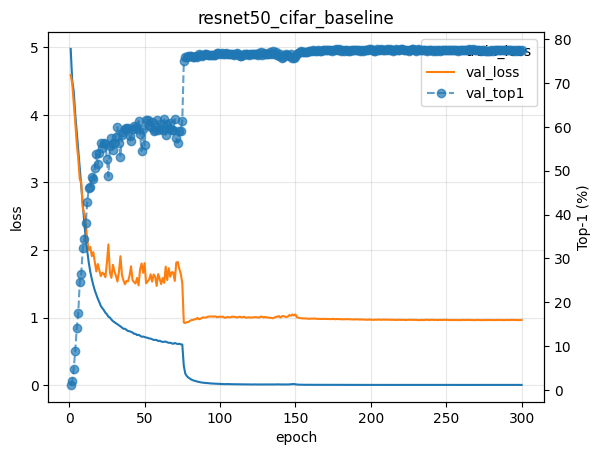


--- Test ---
loss=0.9985  top1=76.52%  top5=93.98%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": None,
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_cifar_baseline = run_experiment("resnet50_cifar_baseline", CONFIG)

## CutMix


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=4.9879  val_loss=4.6048  top1=0.88%  top5=5.32%  lr=0.1
epoch 002 train_loss=4.5959  val_loss=4.5748  top1=1.60%  top5=8.52%  lr=0.1
epoch 003 train_loss=4.5517  val_loss=4.4331  top1=2.24%  top5=11.08%  lr=0.1
epoch 004 train_loss=4.3531  val_loss=4.1420  top1=5.56%  top5=20.90%  lr=0.1
epoch 005 train_loss=4.1614  val_loss=3.8778  top1=8.62%  top5=29.54%  lr=0.1
epoch 006 train_loss=3.9899  val_loss=3.6481  top1=11.92%  top5=36.92%  lr=0.1
epoch 007 train_loss=3.8323  val_loss=3.5219  top1=15.68%  top5=41.46%  lr=0.1
epoch 008 train_loss=3.6992  val_loss=3.2631  top1=20.04%  top5=48.90%  lr=0.1
epoch 009 train_loss=3.5087  val_loss=3.0554  top1=23.18%  top5=54.82%  lr=0.1
epoch 010 train_loss=3.3492  val_loss=2.7517  top1=29.34%  top5=61.78%  lr=0.1
epoch 011 train_loss=3.0868  val_loss=2.6991  top1=32.02%  top5=62.74%  lr=0.1
epoch 012 train_loss=2.9612  val_loss=2.6225  top1=33.4

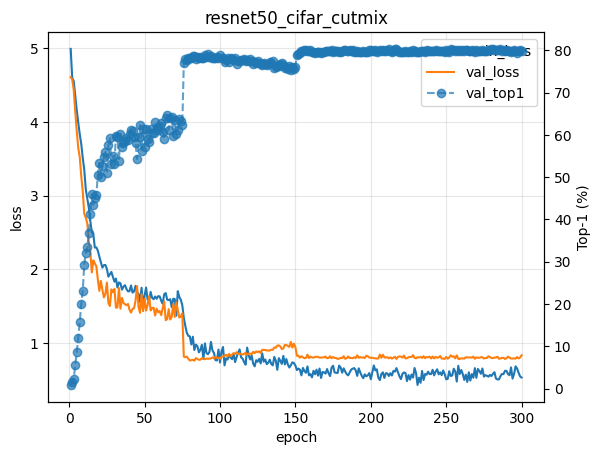


--- Test ---
loss=0.8224  top1=80.75%  top5=95.37%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "cutmix",
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_cifar_cutmix = run_experiment("resnet50_cifar_cutmix", CONFIG)

## Cutout


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=5.0036  val_loss=4.5720  top1=1.40%  top5=7.50%  lr=0.1
epoch 002 train_loss=4.5029  val_loss=4.4590  top1=1.82%  top5=10.18%  lr=0.1
epoch 003 train_loss=4.3537  val_loss=4.1853  top1=3.84%  top5=19.04%  lr=0.1
epoch 004 train_loss=4.1012  val_loss=3.9682  top1=7.10%  top5=25.92%  lr=0.1
epoch 005 train_loss=3.9362  val_loss=3.8457  top1=9.00%  top5=30.56%  lr=0.1
epoch 006 train_loss=3.7811  val_loss=3.6271  top1=13.38%  top5=37.28%  lr=0.1
epoch 007 train_loss=3.6555  val_loss=3.5064  top1=15.38%  top5=40.36%  lr=0.1
epoch 008 train_loss=3.4969  val_loss=3.4132  top1=17.24%  top5=44.38%  lr=0.1
epoch 009 train_loss=3.3275  val_loss=3.1521  top1=21.60%  top5=51.84%  lr=0.1
epoch 010 train_loss=3.1615  val_loss=3.0091  top1=25.10%  top5=55.44%  lr=0.1
epoch 011 train_loss=2.9643  val_loss=2.7353  top1=29.06%  top5=61.90%  lr=0.1
epoch 012 train_loss=2.7804  val_loss=2.6640  top1=32.

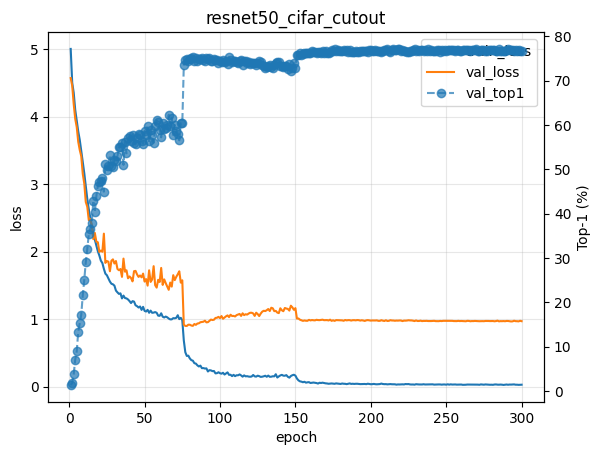


--- Test ---
loss=0.9895  top1=76.03%  top5=93.72%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "cutout",
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_cifar_cutout = run_experiment("resnet50_cifar_cutout", CONFIG)

## Mixup


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=4.9480  val_loss=4.5494  top1=1.64%  top5=7.72%  lr=0.1
epoch 002 train_loss=4.5153  val_loss=4.4356  top1=2.22%  top5=11.66%  lr=0.1
epoch 003 train_loss=4.3410  val_loss=4.0935  top1=5.60%  top5=22.10%  lr=0.1
epoch 004 train_loss=4.1429  val_loss=3.9121  top1=8.78%  top5=28.70%  lr=0.1
epoch 005 train_loss=3.9758  val_loss=3.6493  top1=13.16%  top5=37.54%  lr=0.1
epoch 006 train_loss=3.8202  val_loss=3.4630  top1=16.56%  top5=43.88%  lr=0.1
epoch 007 train_loss=3.6749  val_loss=3.3241  top1=18.92%  top5=47.30%  lr=0.1
epoch 008 train_loss=3.4754  val_loss=3.0935  top1=23.72%  top5=53.12%  lr=0.1
epoch 009 train_loss=3.3355  val_loss=2.8292  top1=28.52%  top5=59.56%  lr=0.1
epoch 010 train_loss=3.1564  val_loss=2.7277  top1=31.50%  top5=62.12%  lr=0.1
epoch 011 train_loss=2.9905  val_loss=2.6083  top1=33.42%  top5=66.12%  lr=0.1
epoch 012 train_loss=2.9127  val_loss=2.3299  top1=38

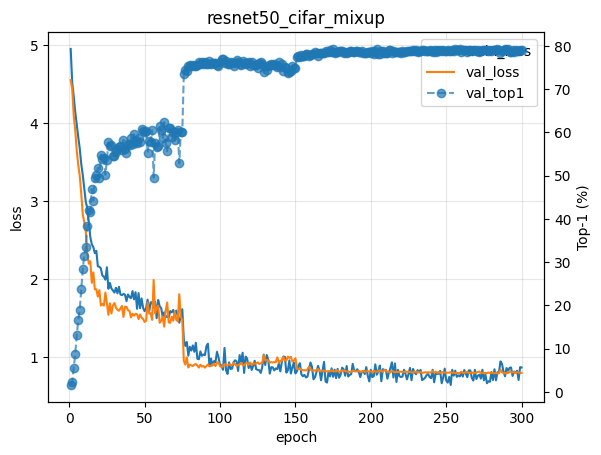


--- Test ---
loss=0.8244  top1=78.41%  top5=94.49%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "mixup",
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_cifar_mixup = run_experiment("resnet50_cifar_mixup", CONFIG)

# ResNet-18 CIFAR-100

## Baseline


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=3.7067  val_loss=3.3702  top1=18.86%  top5=47.44%  lr=0.1
epoch 002 train_loss=2.8538  val_loss=2.6869  top1=32.50%  top5=63.76%  lr=0.1
epoch 003 train_loss=2.3312  val_loss=2.4363  top1=37.22%  top5=68.96%  lr=0.1
epoch 004 train_loss=1.9912  val_loss=2.1399  top1=42.72%  top5=75.18%  lr=0.1
epoch 005 train_loss=1.7520  val_loss=1.9305  top1=48.42%  top5=79.50%  lr=0.1
epoch 006 train_loss=1.5835  val_loss=2.2416  top1=42.78%  top5=74.92%  lr=0.1
epoch 007 train_loss=1.4499  val_loss=1.8853  top1=48.46%  top5=80.44%  lr=0.1
epoch 008 train_loss=1.3450  val_loss=1.7188  top1=52.24%  top5=83.40%  lr=0.1
epoch 009 train_loss=1.2528  val_loss=1.5730  top1=56.80%  top5=85.20%  lr=0.1
epoch 010 train_loss=1.1750  val_loss=1.5975  top1=55.08%  top5=85.16%  lr=0.1
epoch 011 train_loss=1.1171  val_loss=1.5065  top1=58.18%  top5=86.76%  lr=0.1
epoch 012 train_loss=1.0559  val_loss=1.6378  to

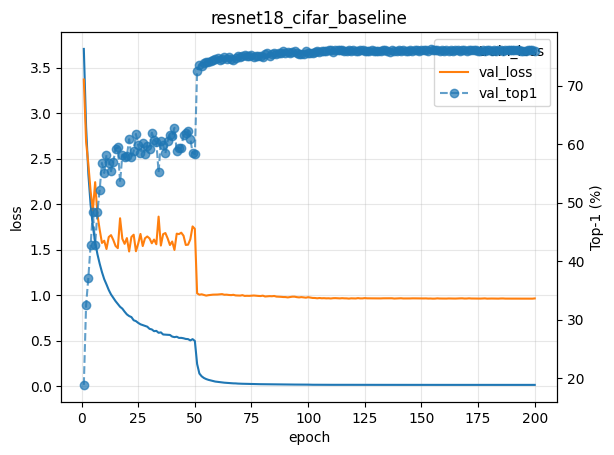


--- Test ---
loss=0.9756  top1=75.67%  top5=93.22%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": None,
    "architecture": "resnet18",
    "epochs": 200,
}

resnet18_cifar_baseline = run_experiment("resnet18_cifar_baseline", CONFIG)

## CutMix


--- Dataset split ---
{'train': 45000, 'val': 5000, 'test': 10000}

--- Train ---
epoch 001 train_loss=4.0297  val_loss=3.5282  top1=16.78%  top5=43.46%  lr=0.1
epoch 002 train_loss=3.5212  val_loss=3.0380  top1=24.50%  top5=54.46%  lr=0.1
epoch 003 train_loss=3.1245  val_loss=2.8766  top1=28.56%  top5=58.14%  lr=0.1
epoch 004 train_loss=2.8989  val_loss=2.4067  top1=37.14%  top5=69.38%  lr=0.1
epoch 005 train_loss=2.6447  val_loss=2.3002  top1=39.66%  top5=71.16%  lr=0.1
epoch 006 train_loss=2.4485  val_loss=2.0161  top1=45.96%  top5=77.04%  lr=0.1
epoch 007 train_loss=2.3714  val_loss=2.1285  top1=43.16%  top5=76.16%  lr=0.1
epoch 008 train_loss=2.3787  val_loss=1.8680  top1=49.78%  top5=80.08%  lr=0.1
epoch 009 train_loss=2.3190  val_loss=1.7537  top1=51.78%  top5=81.84%  lr=0.1
epoch 010 train_loss=2.1925  val_loss=1.8629  top1=49.54%  top5=79.92%  lr=0.1
epoch 011 train_loss=2.1064  val_loss=1.8266  top1=51.10%  top5=81.12%  lr=0.1
epoch 012 train_loss=1.9016  val_loss=1.8636  to

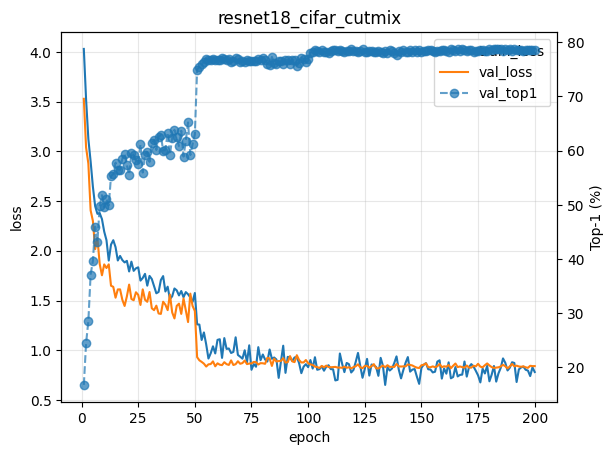


--- Test ---
loss=0.8625  top1=77.42%  top5=93.84%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "cutmix",
    "architecture": "resnet18",
    "epochs": 200,
}

resnet18_cifar_cutmix = run_experiment("resnet18_cifar_cutmix", CONFIG)

## Cutout


--- Dataset stats ---
{'train': 100000, 'val': 5000, 'test': 5000}

--- Build model ---
Model built: ResNet-18 -> 200 classes

--- Fine-tune ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[FT] epoch 01  train_loss=4.0275  val_loss=2.6638  top1=43.68%  top5=71.30%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

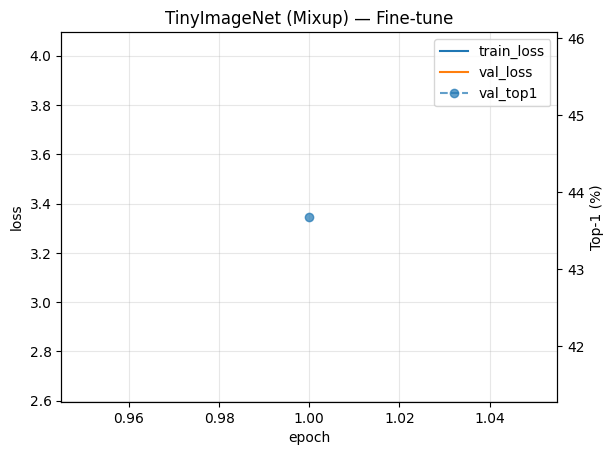


--- Test ---
TinyImageNet (Mixup) Test — loss=2.6638  top1=43.68%  top5=71.30%
Computing confusion matrix on test set...
Confusion matrix complete.


In [ ]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "cutout",
    "architecture": "resnet18",
    "epochs": 200,
}

resnet18_cifar_cutout = run_experiment("resnet18_cifar_cutout", CONFIG)

## MixUp


--- Dataset stats ---
{'train': 100000, 'val': 5000, 'test': 5000}

--- Build model ---
Model built: ResNet-18 -> 200 classes

--- Fine-tune ---


/tmp/ipython-input-2634277791.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


[FT] epoch 01  train_loss=4.1191  val_loss=2.6106  top1=44.90%  top5=72.74%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

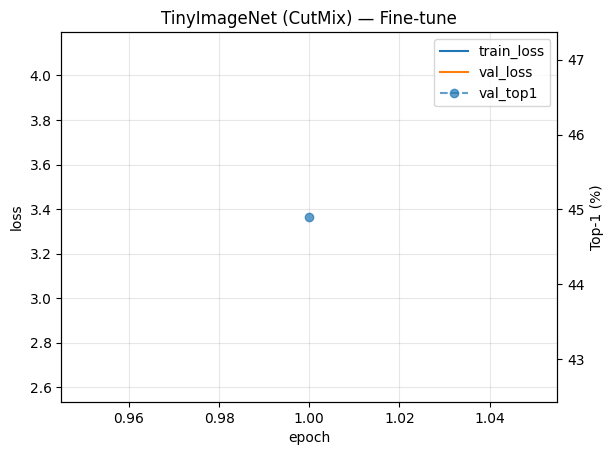


--- Test ---
TinyImageNet (CutMix) Test — loss=2.6106  top1=44.90%  top5=72.74%
Computing confusion matrix on test set...
Confusion matrix complete.


In [ ]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "cifar100",
    "aug_mode": "mixup",
    "architecture": "resnet18",
    "epochs": 200,
}

resnet18_cifar_mixup = run_experiment("resnet18_cifar_mixup", CONFIG)

# ResNet-50 Tiny ImageNet

## Baseline

In [ ]:
CONFIG = GLOBAL_CONFIG | {
    "dataset": "tinyimagenet",
    "aug_mode": None,
    "architecture": "resnet50",
    "epochs": 300,
}

resnet50_tiny_baseline = run_experiment("resnet50_tiny_baseline", CONFIG)

# Comparison

,Model,LP epochs,FT epochs,Best Val Top-1 (%),Best Val Top-5 (%),Best phase@epoch,Test Top-1 (%),Test Top-5 (%),Test loss,Train time (min)
0,ResNet-18,0,1,46.74,78.26,FT@1,46.36,77.55,2.3465,—
1,+ Mixup,0,1,40.26,72.00,FT@1,39.53,71.39,2.6253,—
2,+ Cutout,0,1,42.66,74.56,FT@1,42.39,74.61,2.4918,—
3,+ CutMix,0,1,39.50,72.18,FT@1,39.26,71.98,2.6575,—


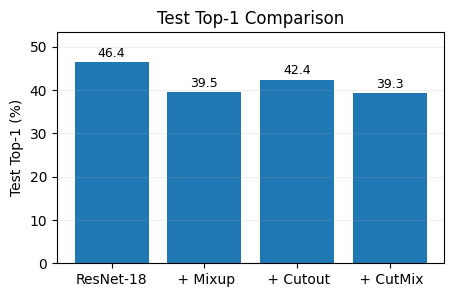

,Model,LP epochs,FT epochs,Best Val Top-1 (%),Best Val Top-5 (%),Best phase@epoch,Test Top-1 (%),Test Top-5 (%),Test loss,Train time (min)
0,Tiny ImageNet,0,1,50.34,77.48,FT@1,50.34,77.48,2.2921,—
1,+ Mixup,0,1,43.68,71.30,FT@1,43.68,71.30,2.6638,—
2,+ Cutout,0,1,48.50,75.98,FT@1,48.50,75.98,2.3501,—
3,+ CutMix,0,1,44.90,72.74,FT@1,44.90,72.74,2.6106,—


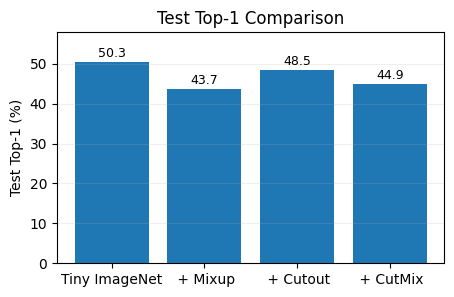

In [ ]:

# Build a compact table of key metrics and a tiny bar chart for Test Top-1.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _best_from_history(hist: dict):
    """Return (best_top1, best_top5, best_epoch_idx) from a history dict, or (nan, nan, -1)."""
    v1 = hist.get("val_top1", []) or []
    v5 = hist.get("val_top5", []) or []
    if len(v1) == 0:
        return np.nan, np.nan, -1
    idx = int(np.nanargmax(np.asarray(v1, dtype=float)))
    best1 = float(v1[idx])
    best5 = float(v5[idx]) if idx < len(v5) and v5[idx] is not None else np.nan
    return best1, best5, idx + 1  # 1-based epoch index

def summarize_results(name: str, res: dict):
    """Extract summary stats from a run_experiment() result dict."""
    lp_hist = res.get("lp_history", {}) or {}
    ft_hist = res.get("ft_history", {}) or {}
    test   = res.get("test_metrics", {}) or {}

    # Epoch counts inferred from histories
    lp_epochs = len(lp_hist.get("val_top1", []) or [])
    ft_epochs = len(ft_hist.get("val_top1", []) or [])

    # Best validation metrics across both phases
    lp_best1, lp_best5, lp_best_ep = _best_from_history(lp_hist)
    ft_best1, ft_best5, ft_best_ep = _best_from_history(ft_hist)

    if np.isnan(lp_best1) and not np.isnan(ft_best1):
        best_val_top1, best_val_top5, best_phase, best_epoch = ft_best1, ft_best5, "FT", ft_best_ep
    elif np.isnan(ft_best1) and not np.isnan(lp_best1):
        best_val_top1, best_val_top5, best_phase, best_epoch = lp_best1, lp_best5, "LP", lp_best_ep
    else:
        # choose the higher top-1; tie-breaker prefers FT
        if ft_best1 >= (lp_best1 if not np.isnan(lp_best1) else -np.inf):
            best_val_top1, best_val_top5, best_phase, best_epoch = ft_best1, ft_best5, "FT", ft_best_ep
        else:
            best_val_top1, best_val_top5, best_phase, best_epoch = lp_best1, lp_best5, "LP", lp_best_ep

    # Test metrics
    test_top1 = float(test.get("top1", np.nan))
    test_top5 = float(test.get("top5", np.nan))
    test_loss = float(test.get("loss", np.nan))

    # Optional training time if available in results; otherwise NaN
    train_time_min = float(res.get("train_time_min", np.nan))

    return {
        "Model": name,
        "LP epochs": lp_epochs,
        "FT epochs": ft_epochs,
        "Best Val Top-1 (%)": round(best_val_top1, 2) if not np.isnan(best_val_top1) else np.nan,
        "Best Val Top-5 (%)": round(best_val_top5, 2) if not np.isnan(best_val_top5) else np.nan,
        "Best phase@epoch": f"{best_phase}@{best_epoch}" if best_epoch != -1 else "—",
        "Test Top-1 (%)": round(test_top1, 2) if not np.isnan(test_top1) else np.nan,
        "Test Top-5 (%)": round(test_top5, 2) if not np.isnan(test_top5) else np.nan,
        "Test loss": round(test_loss, 4) if not np.isnan(test_loss) else np.nan,
        "Train time (min)": round(train_time_min, 1) if not np.isnan(train_time_min) else "—",
    }

# Collect available results; adjust the list below to include your runs
cifar_results = []
if "cifar_baseline" in globals(): cifar_results.append(summarize_results("ResNet-18", cifar_baseline))
if "cifar_mixup"  in globals(): cifar_results.append(summarize_results(" + Mixup", cifar_mixup))
if "cifar_cutout"  in globals(): cifar_results.append(summarize_results(" + Cutout", cifar_cutout))
if "cifar_cutmix"  in globals(): cifar_results.append(summarize_results(" + CutMix", cifar_cutmix))

tiny_results = []
if "tiny_baseline"  in globals(): tiny_results.append(summarize_results("Tiny ImageNet", tiny_baseline))
if "tiny_mixup"  in globals(): tiny_results.append(summarize_results(" + Mixup", tiny_mixup))
if "tiny_cutout"  in globals(): tiny_results.append(summarize_results(" + Cutout", tiny_cutout))
if "tiny_cutmix"  in globals(): tiny_results.append(summarize_results(" + CutMix", tiny_cutmix))

# Create DataFrames
cifar_df = pd.DataFrame(cifar_results, columns=[
    "Model", "LP epochs", "FT epochs",
    "Best Val Top-1 (%)", "Best Val Top-5 (%)", "Best phase@epoch",
    "Test Top-1 (%)", "Test Top-5 (%)", "Test loss",
    "Train time (min)"
])
tiny_df = pd.DataFrame(tiny_results, columns=[
    "Model", "LP epochs", "FT epochs",
    "Best Val Top-1 (%)", "Best Val Top-5 (%)", "Best phase@epoch",
    "Test Top-1 (%)", "Test Top-5 (%)", "Test loss",
    "Train time (min)"
])

# Show table
from IPython.display import display

def show_table(df):
  display(df)

  # Tiny bar chart for Test Top-1
  plt.figure(figsize=(5, 3))
  labels = df["Model"].tolist()
  values = df["Test Top-1 (%)"].astype(float).tolist()
  plt.bar(labels, values)
  plt.ylabel("Test Top-1 (%)")
  plt.title("Test Top-1 Comparison")
  for i, v in enumerate(values):
      plt.text(i, v + 0.5, f"{v:.1f}", ha="center", va="bottom", fontsize=9)
  plt.ylim(0, max(values + [0]) * 1.15 if values else 1)
  plt.grid(axis="y", alpha=0.2)
  plt.show()

show_table(cifar_df)
show_table(tiny_df)

# Create Figures

## Data Augmentation Examples

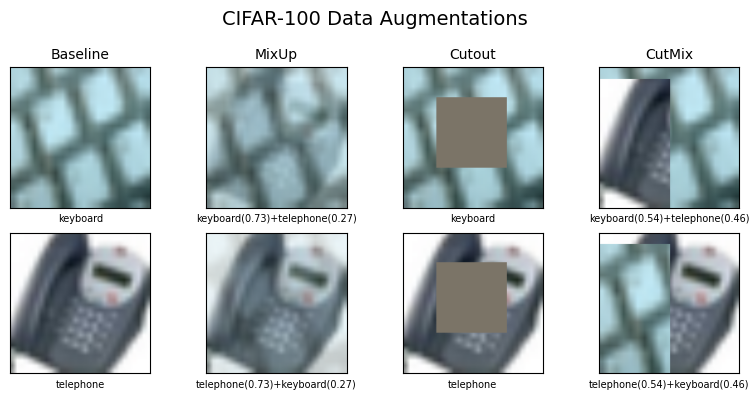

In [ ]:
# === Create Figures for Report / Poster ===
# Assumes you have already run:
#   - run_and_save_linear_probe(...)
#   - res_cifar_baseline, res_cifar_cutout, res_cifar_mixup, res_cifar_cutmix
#   - res_tiny_baseline,  res_tiny_cutout,  res_tiny_mixup,  res_tiny_cutmix
#
# This cell creates:
#   (A) Augmentation examples + labels (CIFAR-100)
#   (B) Linear probe histories (CIFAR-100 + Tiny ImageNet)
#   (C) Fine-tuning histories (CIFAR-100 + Tiny ImageNet)

import numpy as np
import matplotlib.pyplot as plt
import torch

set_seed(3)
# ---------- Helper: apply batch-level augmentation then denorm ----------

def apply_batch_aug(x, y, num_classes, mode: str):
    """
    x: [B,3,H,W] normalized to ImageNet stats
    y: [B] hard labels (int)
    mode: 'baseline' | 'cutout' | 'mixup' | 'cutmix'
    Returns (x_aug, y_aug) where y_aug may be hard or soft labels.
    """
    mode = mode.lower()
    if mode == "baseline":
        return x.clone(), y.clone()

    batch_aug = make_batch_aug(num_classes=num_classes, mode=mode, p=1.0)
    x_aug, y_aug = batch_aug(x.clone(), y.clone())
    return x_aug, y_aug

def _denorm(x, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Invert normalization: x := x*std + mean, then clamp to [0,1]. Works for [B,3,H,W] or [3,H,W]."""
    if mean is None or std is None:
        return x
    if x.dim() == 4:
        m = torch.tensor(mean, device=x.device).view(1, -1, 1, 1)
        s = torch.tensor(std,  device=x.device).view(1, -1, 1, 1)
    else:
        m = torch.tensor(mean, device=x.device).view(-1, 1, 1)
        s = torch.tensor(std,  device=x.device).view(-1, 1, 1)
    return (x * s + m).clamp(0, 1)

def denorm_batch(x):
    """
    x: [B,3,H,W] normalized to ImageNet stats -> return [B,H,W,3] in [0,1] for plotting.
    """
    x = _denorm(x, mean=IMAGENET_MEAN, std=IMAGENET_STD)
    x = x.clamp(0, 1)
    return x.permute(0, 2, 3, 1).cpu().numpy()


def format_soft_label(probs, class_names, topk=2):
    """
    probs: [num_classes] tensor of soft labels.
    Returns a short string like 'fox(0.6)+truck(0.4)'.
    """
    probs = probs.detach().cpu()
    vals, idx = torch.topk(probs, k=topk)
    parts = []
    for v, i in zip(vals, idx):
        parts.append(f"{class_names[int(i)]}({v.item():.2f})")
    return "+".join(parts)


# ======================================================================
# (A) FIGURE: Augmentation examples + labels (CIFAR-100)
# ======================================================================

# Build a small CIFAR-100 train loader (reuses CONFIG / DATA_DIR)
cifar_train_loader, _, _, cifar_classes = build_cifar100_loaders(CONFIG, root=DATA_DIR)

# Take one batch
x_batch, y_batch = next(iter(cifar_train_loader))   # x normalized, y hard labels
x_batch = x_batch.to("cpu")
y_batch = y_batch.to("cpu")

# Use first 2 examples for a compact grid
n_show = 2
x_batch = x_batch[:n_show]
y_batch = y_batch[:n_show]

modes = [
    ("Baseline", "baseline"),
    ("MixUp",    "mixup"),
    ("Cutout",   "cutout"),
    ("CutMix",   "cutmix"),
]

# Precompute augmented batches for each mode
aug_data = []
for aug_name, mode in modes:
    x_aug, y_aug = apply_batch_aug(x_batch, y_batch, num_classes=100, mode=mode)
    x_imgs = denorm_batch(x_aug)

    if not isinstance(y_aug, torch.Tensor):
        y_aug = torch.as_tensor(y_aug)

    aug_data.append((aug_name, x_imgs, y_aug))

# Now: rows = examples, cols = augmentations
fig, axes = plt.subplots(n_show, len(modes),
                         figsize=(2.0 * len(modes), 2.0 * n_show))

for row in range(n_show):  # each example
    for col, (aug_name, x_imgs, y_aug) in enumerate(aug_data):  # each augmentation
        ax = axes[row, col] if n_show > 1 else axes[col]
        ax.imshow(x_imgs[row])
        ax.set_xticks([])
        ax.set_yticks([])

        # Column titles: augmentation names
        if row == 0:
            ax.set_title(aug_name, fontsize=10)

        # Build a short label string for THIS image under THIS aug
        if y_aug.ndim == 1:   # hard labels
            cls_idx = int(y_aug[row].item())
            label_str = cifar_classes[cls_idx]
        else:                 # soft labels (MixUp / CutMix)
            label_str = format_soft_label(y_aug[row], cifar_classes, topk=2)

        # Put the label under the image
        ax.set_xlabel(label_str, fontsize=7)

fig.suptitle("CIFAR-100 Data Augmentations", fontsize=14)
plt.tight_layout()
plt.savefig("fig_augmentations_cifar100.png", dpi=300, bbox_inches="tight")
plt.show()


## Training History

/tmp/ipython-input-2123784482.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


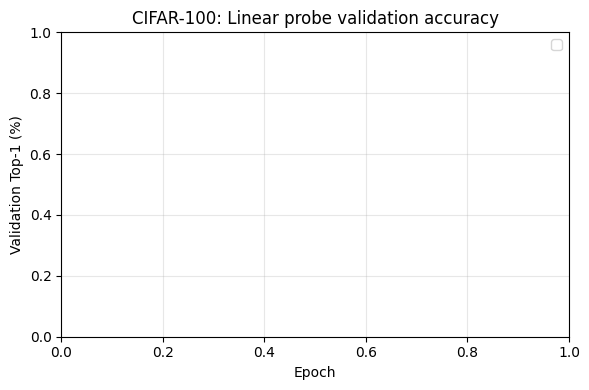

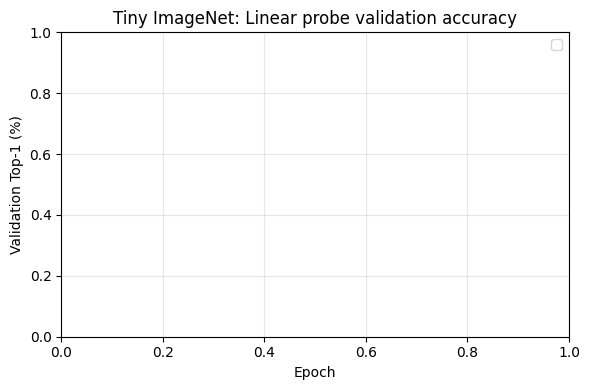

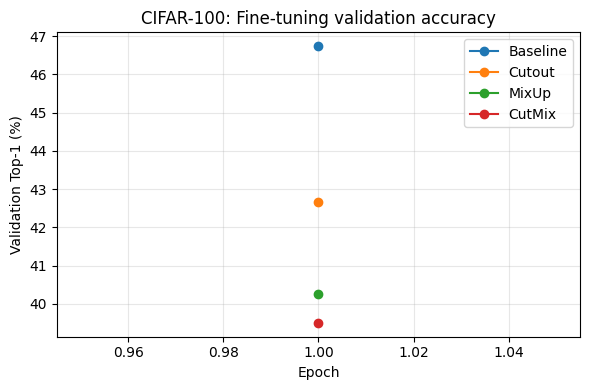

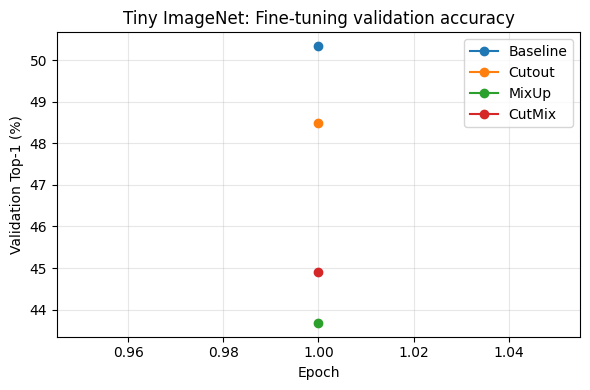

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ======================================================================
# (B) FIGURE: Linear probe histories (val Top-1 vs epoch)
# ======================================================================

def plot_phase_histories(dataset_name, results_dict, phase_key="lp_history",
                         filename="fig_lp_histories.png"):
    """
    dataset_name: string ("CIFAR-100", "Tiny ImageNet")
    results_dict: {label: res_dict} where res_dict comes from run_experiment()
    phase_key: 'lp_history' or 'ft_history'
    """
    plt.figure(figsize=(6, 4))
    for label, res in results_dict.items():
        if res is None:
            continue
        hist = res.get(phase_key, {}) or {}
        ys = hist.get("val_top1", []) or []
        if len(ys) == 0:
            continue
        xs = np.arange(1, len(ys) + 1)
        plt.plot(xs, ys, marker="o", label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Top-1 (%)")
    plt.title(f"{dataset_name}: {('Linear probe' if phase_key=='lp_history' else 'Fine-tuning')} validation accuracy")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# CIFAR-100 linear probe histories
cifar_results_lp = {
    "Baseline": cifar_baseline,
    "Cutout":   cifar_cutout,
    "MixUp":    cifar_mixup,
    "CutMix":   cifar_cutmix,
}
plot_phase_histories("CIFAR-100", cifar_results_lp,
                     phase_key="lp_history",
                     filename="fig_lp_histories_cifar100.png")

# Tiny ImageNet linear probe histories (if available)
tiny_results_lp = {
    "Baseline": tiny_baseline,
    "Cutout":   tiny_cutout,
    "MixUp":    tiny_mixup,
    "CutMix":   tiny_cutmix,
}
plot_phase_histories("Tiny ImageNet", tiny_results_lp,
                      phase_key="lp_history",
                      filename="fig_lp_histories_tiny.png")


# ======================================================================
# (C) FIGURE: Fine-tuning histories (val Top-1 vs epoch)
# ======================================================================

# CIFAR-100 fine-tuning histories
plot_phase_histories("CIFAR-100", cifar_results_lp,
                     phase_key="ft_history",
                     filename="fig_ft_histories_cifar100.png")

plot_phase_histories("Tiny ImageNet", tiny_results_lp,
                      phase_key="ft_history",
                      filename="fig_ft_histories_tiny.png")